In [22]:
# import warnings; warnings.filterwarnings("ignore")
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.quantum_info import Pauli

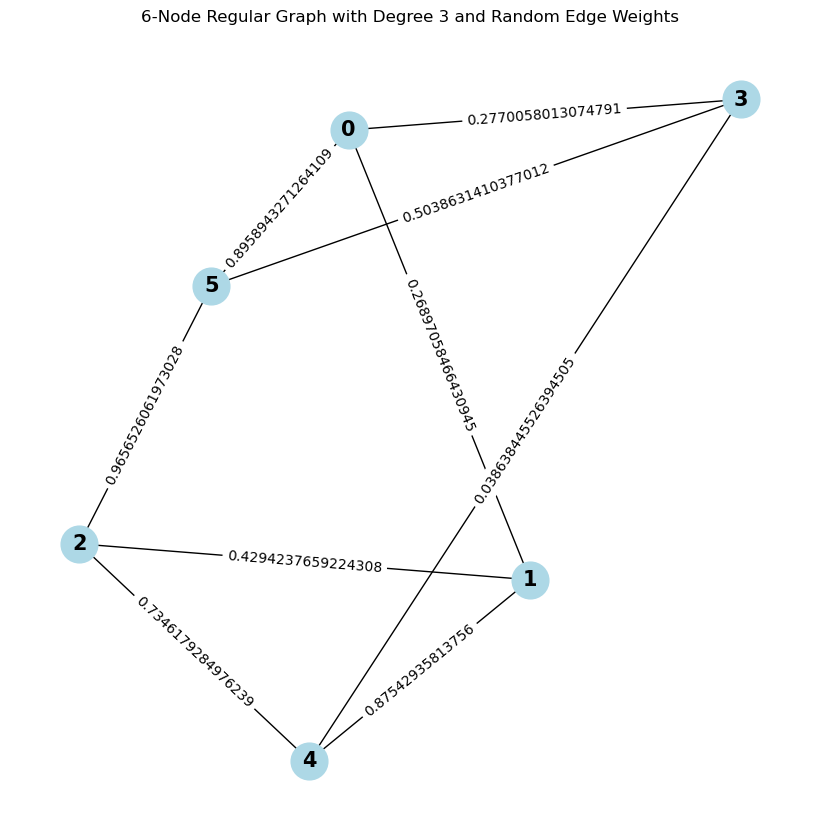

In [23]:
# 生成一个度为 3 的正则图（6个顶点）
n = 6  # 顶点数
degree = 3  # 每个顶点的度数

# 创建正则图
G = nx.random_regular_graph(degree, n)

# 为每条边分配一个随机的权重（在 [0, 1] 范围内）
for u, v in G.edges():
    G[u][v]['weight'] = np.random.uniform(0, 1)

# 计算节点的位置（使用 spring_layout 或其他布局方法）
pos = nx.spring_layout(G, seed=42)  # 使用 Spring 布局计算节点位置

# 绘制图形
plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=15, font_weight='bold')

# 显示边的权重
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# 显示图形
plt.title("6-Node Regular Graph with Degree 3 and Random Edge Weights")
plt.show()


In [24]:
# G = nx.Graph()
# G.add_edges_from([[0,3],[0,4],[1,3],[1,4],[2,3],[2,4]])
#
# # 计算节点的位置
# nx.draw(G, pos=nx.bipartite_layout(G, [0,1,2]))

In [25]:
# 在两个量子比特上添加 zz 门
def append_zz_term(qc, q1, q2, gamma):
    qc.cx(q1, q2)
    qc.rz(2 * gamma, q2)
    qc.cx(q1, q2)


# 在图中每两个节点中添加 zz 门
def get_cost_operator_circuit(G, gamma, qc):
    N = G.number_of_nodes()
    # qc = QuantumCircuit(N,N) # 包含N个量子比特和N个经典比特
    for i, j in G.edges():
        append_zz_term(qc, i, j, gamma)
    return qc


In [26]:
N = G.number_of_nodes()
qc = QuantumCircuit(N, N)
get_cost_operator_circuit(G, np.pi / 3, qc)
qc.draw()

»
q_0: ──■────────────────■────■────────────────────────────■─────────■──»
     ┌─┴─┐┌──────────┐┌─┴─┐  │                            │         │  »
q_1: ┤ X ├┤ Rz(2π/3) ├┤ X ├──┼───────■────────────────────┼────■────┼──»
     └───┘└──────────┘└───┘  │     ┌─┴─┐    ┌──────────┐  │  ┌─┴─┐  │  »
q_2: ────────────────────────┼─────┤ X ├────┤ Rz(2π/3) ├──┼──┤ X ├──┼──»
                           ┌─┴─┐┌──┴───┴───┐└──────────┘┌─┴─┐└───┘  │  »
q_3: ──────────────────────┤ X ├┤ Rz(2π/3) ├────────────┤ X ├───────┼──»
                           └───┘└──────────┘            └───┘       │  »
q_4: ───────────────────────────────────────────────────────────────┼──»
                                                                  ┌─┴─┐»
q_5: ─────────────────────────────────────────────────────────────┤ X ├»
                                                                  └───┘»
c: 6/══════════════════════════════════════════════════════════════════»
                                                                       »
«                                                                              »
«q_0: ──────────────────────────■──────────────────────────────────────────────»
«                               │                                              »
«q_1: ─────■────────────────────┼────■─────────────────────────────────────────»
«          │                    │    │                                         »
«q_2: ─────┼────────────────────┼────┼────■────────────────■────■──────────────»
«          │                    │    │    │                │    │     ┌───┐    »
«q_3: ─────┼────────────────────┼────┼────┼────────────────┼────┼─────┤ X ├────»
«        ┌─┴─┐    ┌──────────┐  │  ┌─┴─┐┌─┴─┐┌──────────┐┌─┴─┐  │     └─┬─┘    »
«q_4: ───┤ X ├────┤ Rz(2π/3) ├──┼──┤ X ├┤ X ├┤ Rz(2π/3) ├┤ X ├──┼───────■──────»
«     ┌──┴───┴───┐└──────────┘┌─┴─┐└───┘└───┘└──────────┘└───┘┌─┴─┐┌──────────┐»
«q_5: ┤ Rz(2π/3) ├────────────┤ X ├───────────────────────────┤ X ├┤ Rz(2π/3) ├»
«     └──────────┘            └───┘                           └───┘└──────────┘»
«c: 6/═════════════════════════════════════════════════════════════════════════»
«                                                                              »
«                                                 
«q_0: ────────────────────────────────────────────
«                                                 
«q_1: ────────────────────────────────────────────
«                                                 
«q_2: ──────────────■─────────────────────────────
«     ┌──────────┐  │  ┌───┐                      
«q_3: ┤ Rz(2π/3) ├──┼──┤ X ├──■────────────────■──
«     └──────────┘  │  └─┬─┘  │                │  
«q_4: ──────────────┼────■────┼────────────────┼──
«                 ┌─┴─┐     ┌─┴─┐┌──────────┐┌─┴─┐
«q_5: ────────────┤ X ├─────┤ X ├┤ Rz(2π/3) ├┤ X ├
«                 └───┘     └───┘└──────────┘└───┘
«c: 6/════════════════════════════════════════════
«

In [27]:
def append_x_term(qc, q1, beta):
    qc.rx(2 * beta, q1)


def get_mixer_operator_circuit(G, beta, qc):
    # N = G.number_of_nodes()
    # qc = QuantumCircuit(N,N)
    for n in G.nodes():
        append_x_term(qc, n, beta)
    return qc


In [28]:
N = G.number_of_nodes()
qc = QuantumCircuit(N, N)
get_mixer_operator_circuit(G, np.pi / 3, qc)
qc.draw()

┌──────────┐
q_0: ┤ Rx(2π/3) ├
     ├──────────┤
q_1: ┤ Rx(2π/3) ├
     ├──────────┤
q_2: ┤ Rx(2π/3) ├
     ├──────────┤
q_3: ┤ Rx(2π/3) ├
     ├──────────┤
q_4: ┤ Rx(2π/3) ├
     ├──────────┤
q_5: ┤ Rx(2π/3) ├
     └──────────┘
c: 6/════════════

In [29]:
def get_qaoa_circuit(G, beta, gamma):
    assert (len(beta) == len(gamma))
    p = len(beta)  # infering number of QAOA steps from the parameters passed
    N = G.number_of_nodes()
    qc = QuantumCircuit(N, N)
    # first, apply a layer of Hadamards
    qc.h(range(N))
    # second, apply p alternating operators
    for i in range(p):
        get_cost_operator_circuit(G, gamma[i], qc)
        get_mixer_operator_circuit(G, beta[i], qc)
    # finally, do not forget to measure the result!
    qc.barrier(range(N))
    qc.measure(range(N), range(N))
    return qc

In [30]:
qc = get_qaoa_circuit(G, [np.pi / 3], [np.pi / 2])
qc.draw()

┌───┐                                                                  »
q_0: ┤ H ├──■─────────────■────■──────────────────────■─────────■───────────»
     ├───┤┌─┴─┐┌───────┐┌─┴─┐  │                      │         │           »
q_1: ┤ H ├┤ X ├┤ Rz(π) ├┤ X ├──┼──────■───────────────┼────■────┼──────■────»
     ├───┤└───┘└───────┘└───┘  │    ┌─┴─┐  ┌───────┐  │  ┌─┴─┐  │      │    »
q_2: ┤ H ├─────────────────────┼────┤ X ├──┤ Rz(π) ├──┼──┤ X ├──┼──────┼────»
     ├───┤                   ┌─┴─┐┌─┴───┴─┐└───────┘┌─┴─┐└───┘  │      │    »
q_3: ┤ H ├───────────────────┤ X ├┤ Rz(π) ├─────────┤ X ├───────┼──────┼────»
     ├───┤                   └───┘└───────┘         └───┘       │    ┌─┴─┐  »
q_4: ┤ H ├──────────────────────────────────────────────────────┼────┤ X ├──»
     ├───┤                                                    ┌─┴─┐┌─┴───┴─┐»
q_5: ┤ H ├────────────────────────────────────────────────────┤ X ├┤ Rz(π) ├»
     └───┘                                                    └───┘└───────┘»
c: 6/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«                   ┌──────────┐                                        »
«q_0: ───────────■──┤ Rx(2π/3) ├────────────────────────────────────────»
«                │  └──────────┘┌──────────┐                            »
«q_1: ───────────┼───────■──────┤ Rx(2π/3) ├────────────────────────────»
«                │       │      └──────────┘                            »
«q_2: ───────────┼───────┼───────────■─────────────────■────■───────────»
«                │       │           │                 │    │    ┌───┐  »
«q_3: ───────────┼───────┼───────────┼─────────────────┼────┼────┤ X ├──»
«     ┌───────┐  │     ┌─┴─┐       ┌─┴─┐    ┌───────┐┌─┴─┐  │    └─┬─┘  »
«q_4: ┤ Rz(π) ├──┼─────┤ X ├───────┤ X ├────┤ Rz(π) ├┤ X ├──┼──────■────»
«     └───────┘┌─┴─┐   └───┘       └───┘    └───────┘└───┘┌─┴─┐┌───────┐»
«q_5: ─────────┤ X ├──────────────────────────────────────┤ X ├┤ Rz(π) ├»
«              └───┘                                      └───┘└───────┘»
«c: 6/══════════════════════════════════════════════════════════════════»
«                                                                       »
«                                                                  ░ ┌─┐      »
«q_0: ─────────────────────────────────────────────────────────────░─┤M├──────»
«                                                                  ░ └╥┘┌─┐   »
«q_1: ─────────────────────────────────────────────────────────────░──╫─┤M├───»
«                   ┌──────────┐                                   ░  ║ └╥┘┌─┐»
«q_2: ───────────■──┤ Rx(2π/3) ├───────────────────────────────────░──╫──╫─┤M├»
«     ┌───────┐  │  └──┬───┬───┘                      ┌──────────┐ ░  ║  ║ └╥┘»
«q_3: ┤ Rz(π) ├──┼─────┤ X ├──────■────────────────■──┤ Rx(2π/3) ├─░──╫──╫──╫─»
«     └───────┘  │     └─┬─┘      │  ┌──────────┐  │  └──────────┘ ░  ║  ║  ║ »
«q_4: ───────────┼───────■────────┼──┤ Rx(2π/3) ├──┼───────────────░──╫──╫──╫─»
«              ┌─┴─┐            ┌─┴─┐└┬───────┬─┘┌─┴─┐┌──────────┐ ░  ║  ║  ║ »
«q_5: ─────────┤ X ├────────────┤ X ├─┤ Rz(π) ├──┤ X ├┤ Rx(2π/3) ├─░──╫──╫──╫─»
«              └───┘            └───┘ └───────┘  └───┘└──────────┘ ░  ║  ║  ║ »
«c: 6/════════════════════════════════════════════════════════════════╩══╩══╩═»
«                                                                     0  1  2 »
«              
«q_0: ─────────
«              
«q_1: ─────────
«              
«q_2: ─────────
«     ┌─┐      
«q_3: ┤M├──────
«     └╥┘┌─┐   
«q_4: ─╫─┤M├───
«      ║ └╥┘┌─┐
«q_5: ─╫──╫─┤M├
«      ║  ║ └╥┘
«c: 6/═╩══╩══╩═
«      3  4  5

In [31]:
def invert_counts(counts):
    return {k[::-1]: v for k, v in counts.items()}

In [32]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend)
result = job.result()
print(invert_counts(result.get_counts()))

C:\Users\李华宪\AppData\Local\Temp\ipykernel_73696\1339924558.py:2: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  job = execute(qc, backend)


{'100001': 13, '010100': 21, '111111': 19, '011011': 8, '100000': 19, '010101': 9, '010000': 24, '110101': 20, '101011': 19, '000100': 16, '100011': 15, '011000': 13, '111101': 20, '110111': 19, '101001': 10, '011100': 14, '001100': 14, '110001': 14, '101111': 16, '111010': 24, '101100': 6, '001111': 17, '001001': 20, '111100': 21, '010111': 14, '011001': 20, '001000': 20, '110011': 21, '101101': 16, '010010': 14, '010110': 14, '011101': 7, '010011': 14, '101000': 21, '111011': 16, '000000': 14, '101110': 17, '001010': 14, '100111': 24, '100100': 19, '110110': 14, '110100': 15, '010001': 15, '011111': 16, '101010': 16, '100010': 15, '000101': 19, '111110': 23, '001011': 10, '001101': 20, '110000': 17, '000011': 14, '111000': 17, '000010': 16, '011110': 21, '100101': 12, '100110': 14, '000110': 15, '000111': 13, '110010': 16, '011010': 12, '000001': 18, '111001': 6, '001110': 14}


In [34]:
def maxcut_obj(x, G):
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            # the edge is cut
            cut -= 1
    return cut


maxcut_obj('000111', G)

-5

In [35]:
def compute_maxcut_energy(counts, G):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():  # meas 表示测量结果的字符串， meas_count 表示该测量结果的计数
        obj_for_meas = maxcut_obj(meas, G)  #调用函数获得单个字符串能量值
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return energy / total_counts  #获得平均能量值

# compute_maxcut_energy(invert_counts(result.get_counts()), G)

-4.408203125

In [ ]:
# 定义成本函数
def cost_function(params):
    length = len(params)
    beta, gamma = params[:length // 2], params[length // 2:]
    qc = QuantumCircuit(N, N)
    qc.h(range(N))
    # 生成 k 层量子线路
    for i in range(length // 2 - 1):
        get_cost_operator_circuit(G, gamma, qc)
        get_mixer_operator_circuit(G, beta, qc)

In [36]:
def get_black_box_objective(G, p):
    backend = Aer.get_backend('qasm_simulator')

    def f(theta):
        # let's assume first half is betas, second half is gammas
        beta = theta[:p]  # 将参数 θ 的前半部分视为 β，后半部分视为 γ
        gamma = theta[p:]
        qc = get_qaoa_circuit(G, beta, gamma)

        # 在模拟器上运行量子电路，并获取测量结果
        counts = execute(qc, backend, seed_simulator=10).result().get_counts()
        # return the energy
        return compute_maxcut_energy(invert_counts(counts), G)

    return f

In [ ]:
# 优化 QAOA 参数
def optimize_qaoa(params, mixers):
    def objective(params):
        expectation, _ = cost_function(params, mixers)

        return expectation

    optimizer = COBYLA(rhobeg=1.5, tol=1e-8)
    # params = np.random.rand(2 * p_max) * 2 * np.pi
    result = optimizer.minimize(fun=objective, x0=params)

    return result

In [37]:
# p is the number of QAOA alternating operators
p = 5
obj = get_black_box_objective(G, p)  # 计算平均能量

# 一组初始化参数的数组
init_point = np.array([0.81069872, 2.2067517, 0.83830696, 2.15579759, 0.37060699,
                       2.42068091, 6.1575306, 2.2453419, 3.85060091, 6.137845])
# We are going to limit the number of iterations to 2500
res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter': 2500, 'disp': True})
res_sample

C:\Users\李华宪\AppData\Local\Temp\ipykernel_73696\3890756471.py:10: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  counts = execute(qc, backend, seed_simulator=10).result().get_counts()


     fun: -5.8427734375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 108
  status: 1
 success: True
       x: array([1.57027332, 2.32496542, 0.74147392, 2.06178436, 0.3211673 ,
       2.36054244, 6.22180793, 2.20021971, 3.71080869, 5.93237573])

In [ ]:
from numpy import ComplexWarning
import warnings
import time

# 忽略弃用警告
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=ComplexWarning)
# 运行优化
startTime = time.time()
ansatz_final = object()
init_point = np.array([])
counts = {}
min_energy = 0
final_result = object()
mixers_final = []
for p1 in range(1, 3):
    min_energy = 10000
    for k in range(30):
        print('第：', p1, '层', ' ', '第', k, '个参数')
        init_point_temp = init_point
        mixers = mixers_final
        beta_p = np.random.uniform(0, np.pi)
        gamma_p = np.random.uniform(0, 2 * np.pi)
        if k > 0:
            init_point_temp = np.delete(init_point_temp, 2 * p1 - 1)
            init_point_temp = np.delete(init_point_temp, p1 - 1)
            # mixers.pop(p1 - 1)
        init_point_temp = np.insert(init_point_temp, p1 - 1, beta_p)
        init_point_temp = np.insert(init_point_temp, 2 * p1 - 1, gamma_p)
        ###
        # mixers.append(adapt_qaoa(init_point_temp, mixers))
        result = optimize_qaoa(init_point_temp, mixers)
        # print(result.x)
        optimal_params = result.x
        # 计算最终的能量
        energy, counts_temp = cost_function(result.x, mixers)
        if min_energy > energy:
            min_energy = energy
            init_point = optimal_params
            counts = counts_temp
            final_result = result
            mixers_final = mixers
endTime = time.time()

In [38]:
optimal_theta = res_sample['x']
qc = get_qaoa_circuit(G, optimal_theta[:p], optimal_theta[p:])
counts = invert_counts(execute(qc, backend).result().get_counts())
counts

C:\Users\李华宪\AppData\Local\Temp\ipykernel_73696\2582506423.py:3: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  counts = invert_counts(execute(qc, backend).result().get_counts())


{'111000': 2,
 '000011': 32,
 '011010': 32,
 '101100': 56,
 '001111': 5,
 '001001': 6,
 '111101': 1,
 '011000': 4,
 '100011': 66,
 '101110': 40,
 '010011': 45,
 '101000': 34,
 '011101': 31,
 '100001': 2,
 '111111': 10,
 '010100': 31,
 '011011': 7,
 '010101': 57,
 '001110': 6,
 '101101': 4,
 '110011': 37,
 '101010': 59,
 '110101': 7,
 '101011': 38,
 '100100': 5,
 '010111': 29,
 '011001': 3,
 '111100': 42,
 '011111': 1,
 '110100': 6,
 '010001': 44,
 '100010': 34,
 '101001': 2,
 '011100': 65,
 '100101': 34,
 '101111': 2,
 '110001': 5,
 '001100': 38,
 '100110': 6,
 '001011': 6,
 '001101': 5,
 '110000': 5,
 '111010': 8,
 '000000': 11,
 '110110': 8,
 '010110': 7,
 '000111': 6,
 '000101': 7,
 '000110': 5,
 '110010': 2,
 '111001': 10,
 '001010': 3,
 '100111': 4,
 '010010': 5,
 '011110': 3,
 '000100': 1}

<BarContainer object of 6 artists>

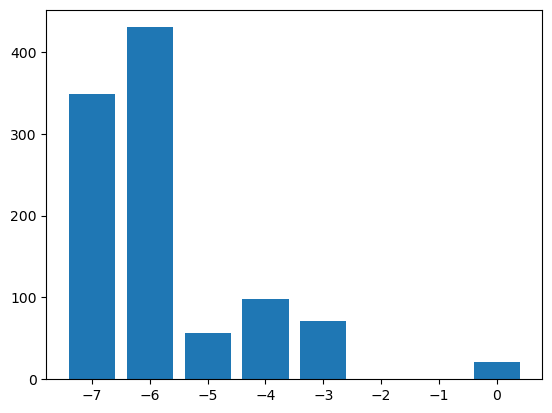

In [39]:
# 创建了一个默认值为 0 的字典 energies，用于存储每个最大割问题能量的计数
energies = defaultdict(int)
# 每个键 k 是一个表示测量结果的字符串，每个值 v 是该测量结果的计数
for k, v in counts.items():
    energies[maxcut_obj(k, G)] += v

# 将字典 energies 中的键值对分别提取出来，分别存储在 x 和 y 中。
# x 是能量值，y 是对应的计数
x, y = zip(*energies.items())
plt.bar(x, y)

Best string: 101100 with cut: 7


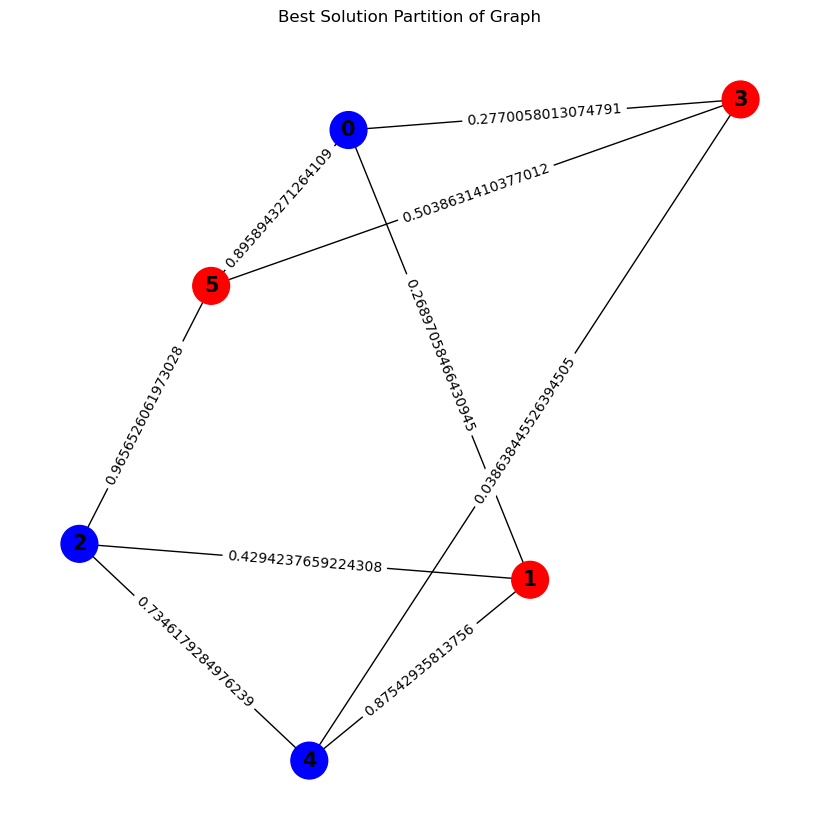

In [41]:
# get the best solution:
# 从 counts 字典中选择最佳解
best_cut, best_solution = min([(maxcut_obj(x, G), x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

# 根据最佳解对节点进行着色
colors = ['r' if best_solution[i] == '0' else 'b' for i in range(n)]

# 绘制图，使用 spring_layout 或其他布局
pos = nx.spring_layout(G, seed=42)  # 使用 Spring 布局计算节点位置
plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True, node_size=700, node_color=colors, font_size=15, font_weight='bold')

# 显示边的权重
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# 显示图形
plt.title("Best Solution Partition of Graph")
plt.show()
# # color the graph nodes by part
# colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
# nx.draw(G,node_color = colors, pos=nx.bipartite_layout(G, [0,1,2]))